In [1]:
from tqdm import tqdm 

In [2]:
from functools import partial

import bpd

from jax import jit, vmap

import jax.numpy as jnp

from bpd.sample import sample_noisy_ellipticities_unclipped
from bpd.pipelines import logtarget_toy_ellips, pipeline_shear_inference_simple

from bpd.chains import run_inference_nuts

from jax import random

import matplotlib.pyplot as plt 

In [4]:
def get_mbias_mc(seed:int, g1=0.02, g2=0.0, n_gals=100, shape_noise=1e-3 , sigma_m=1e-5, n_samples_gals=300, n_samples_shear=1000,):
    k = random.key(seed)
    k1, k2, k3 = random.split(k, 3 )
    true_g = jnp.array([g1, g2])


    # same ellipticities with same noise, but opposite shear
    e_obs_plus, e_sheared_plus, e_int = sample_noisy_ellipticities_unclipped(
        k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=n_gals
    )
    e_obs_minus, e_sheared_minus, _ = sample_noisy_ellipticities_unclipped(
        k1, g=-true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=n_gals
    )

    sigma_e_int = max([2 * shape_noise, 5e-2])

    
    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(k2, (n_gals, 2))

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples_gals,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2, 0], e_obs_plus[:2], e_sheared_plus[:2])
    
    e1e2p = pipe(k2s[:, 0], e_obs_plus, e_int)
    e1e2m = pipe(k2s[:, 1], e_obs_minus, e_int)


    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples_shear,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)

    k31, k32 = random.split(k3)

    gp = pipe(k31, e1e2p)
    gm = pipe(k32, e1e2m)

    m = (gp[..., 0].mean() - gm[..., 0].mean()) / 2 / 0.02 - 1 

    return m.mean(), gp , gm
    

In [5]:
def get_mbias_mc_same(seed:int, g1=0.02, g2=0.0, n_gals=100, shape_noise=1e-3, sigma_e_int=5e-2, sigma_m=1e-5, n_samples_gals=300, n_samples_shear=1000,):
    k = random.key(seed)
    k1, k2, k3 = random.split(k, 3 )
    true_g = jnp.array([g1, g2])


    # same ellipticities with same noise, but opposite shear
    e_obs_plus, e_sheared_plus, e_int = sample_noisy_ellipticities_unclipped(
        k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=n_gals
    )
    e_obs_minus, e_sheared_minus, _ = sample_noisy_ellipticities_unclipped(
        k1, g=-true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=n_gals
    )

    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(k2, n_gals)

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples_gals,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2], e_obs_plus[:2], e_int[:2])
    
    e1e2p = pipe(k2s, e_obs_plus, e_int)
    e1e2m = pipe(k2s, e_obs_minus, e_int)


    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise ,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples_shear,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)


    gp = pipe(k3, e1e2p)
    gm = pipe(k3, e1e2m)

    assert gp.ndim == 2
    m = (gp[..., 0].mean() - gm[..., 0].mean()) / 2 / 0.02 - 1 

    return m, gp, gm, e1e2p, e1e2m, e_sheared_plus, e_sheared_minus

## Different seeds

In [137]:
_func = jit(
    partial(
        get_mbias_mc, shape_noise=0.1
    )
)

In [140]:
_ = _func(42)

In [141]:
# seeds = jnp.array([42, 43])
seeds = jnp.arange(100)
seeds.shape

(100,)

In [142]:
ms, gp, gm = vmap(_func)(seeds)
ms.shape, gp.shape

((100,), (100, 1000, 2))

(array([ 1.,  1.,  0.,  2.,  4., 10.,  4.,  6.,  8.,  9., 13.,  8.,  7.,
         9.,  7.,  4.,  1.,  3.,  2.,  0.,  1.]),
 array([-0.51117461, -0.50901148, -0.50684835, -0.50468523, -0.5025221 ,
        -0.50035898, -0.49819585, -0.49603273, -0.4938696 , -0.49170648,
        -0.48954335, -0.48738023, -0.4852171 , -0.48305397, -0.48089085,
        -0.47872772, -0.4765646 , -0.47440147, -0.47223835, -0.47007522,
        -0.4679121 , -0.46574897]),
 <BarContainer object of 21 artists>)

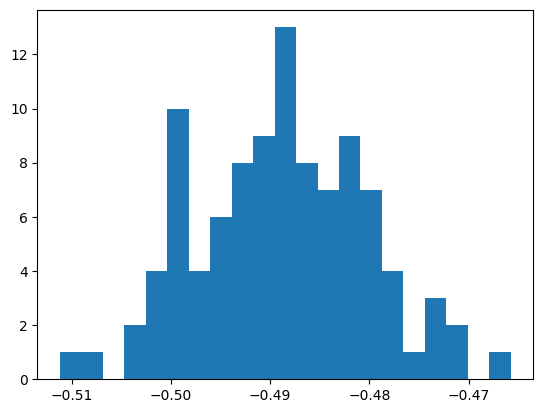

In [143]:
plt.hist(ms, bins=21)

In [144]:
ms.mean(), ms.std()

(Array(-0.48878606, dtype=float64), Array(0.00857287, dtype=float64))

In [145]:
ms.mean() / ms.std()

Array(-57.0154414, dtype=float64)

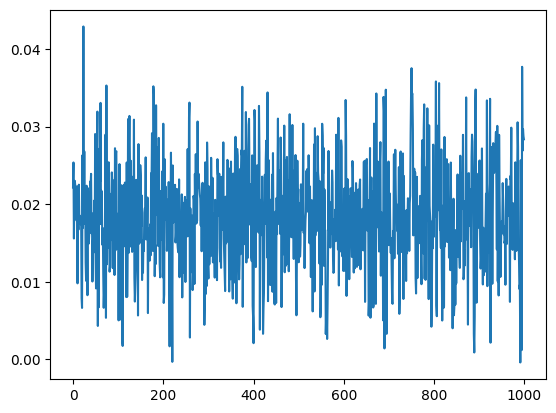

In [153]:
plt.plot(gp[0, :, 0])

In [156]:
gp[2, :, 0].mean()

Array(0.01739998, dtype=float64)

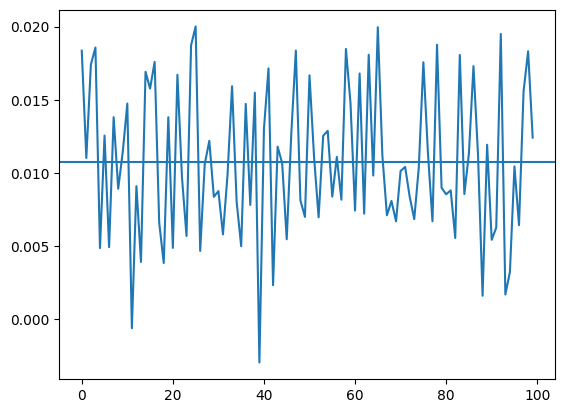

In [158]:
plt.plot(gp[...,0].mean(axis=1))
plt.axhline(gp[...,0].mean(axis=1).mean())

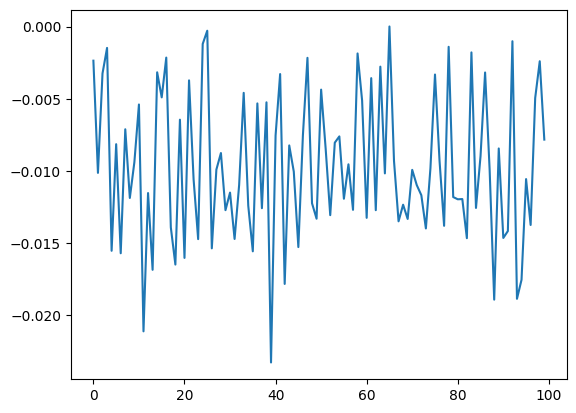

In [151]:
plt.plot(gm[...,0].mean(axis=1))

## Same seed

In [9]:
_func = jit(
    partial(
        get_mbias_mc_same, shape_noise=1e-2, n_gals=10000
    )
)

In [10]:
_func(42); # jitting

In [11]:
# # seeds = jnp.array([42, 43])
# seeds = jnp.arange(100)
# seeds.shape

In [12]:
# get array of seeds from numpy
import numpy as np 
rng = np.random.RandomState(322)
seeds = rng.uniform(low=0, high=2**31, size=(100,)).astype(int)
seeds = jnp.array(seeds)
seeds.shape

(100,)

In [15]:
ms =[] 
gps = [] 
gms = [] 

for ii in tqdm(range(10)):
    _seeds = seeds[ii*10:(ii+1)*10]
    ms2, gp, gm, _, _, _, _ = vmap(_func)(_seeds)
    ms.append(ms2)
    gps.append(gp)
    gms.append(gm)

100%|██████████| 10/10 [18:05<00:00, 108.53s/it]


In [19]:
ms2 = jnp.concatenate(ms, axis=0)

In [20]:
ms2.shape

(100,)

In [21]:
ms2.mean()

Array(-0.0001036, dtype=float64)

In [22]:
ms2.std()

Array(4.04115461e-05, dtype=float64)

In [24]:
ms2.mean() / ms2.std()

Array(-2.56374126, dtype=float64)

(array([ 2.,  3.,  1.,  5.,  7., 17., 47., 10.,  4.,  3.,  1.]),
 array([-2.43068282e-04, -2.19711536e-04, -1.96354791e-04, -1.72998045e-04,
        -1.49641299e-04, -1.26284553e-04, -1.02927807e-04, -7.95710615e-05,
        -5.62143157e-05, -3.28575699e-05, -9.50082402e-06,  1.38559218e-05]),
 <BarContainer object of 11 artists>)

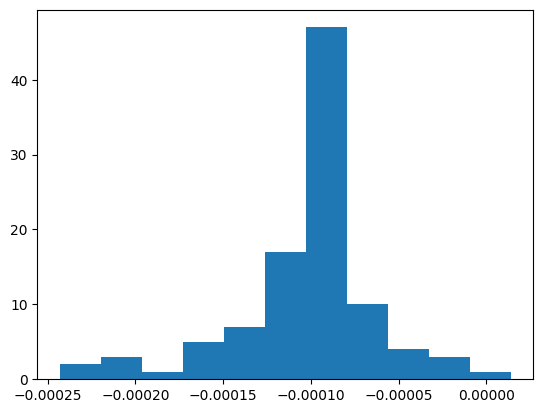

In [23]:
plt.hist(ms2, bins=11)

In [56]:
ep.shape

(100, 1000, 2)

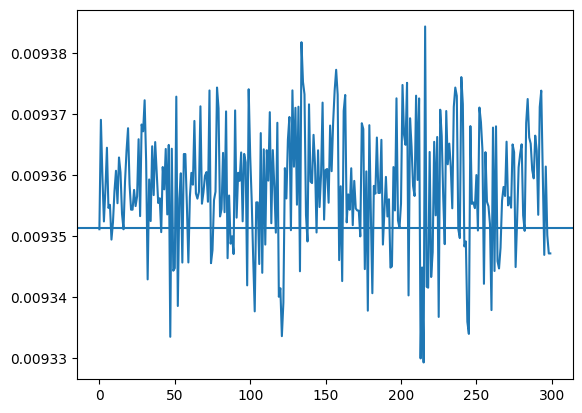

In [57]:
# check ellipticity samples 
plt.plot(e1e2p[11, 0, :, 0])
plt.axhline(ep[11, 0, 0])

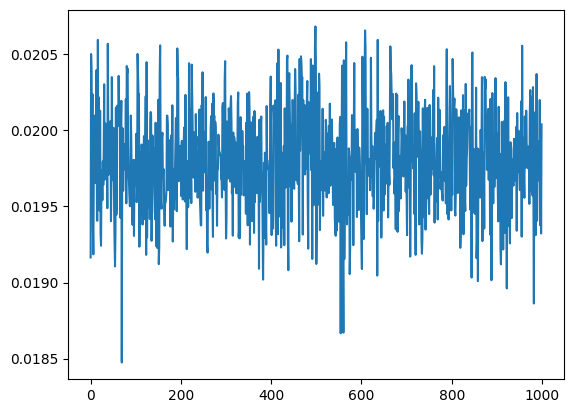

In [58]:

plt.plot(gp[5, :, 0])

In [59]:
ep.shape

(100, 1000, 2)

In [60]:
_mtrue = (ep - em) / 2 / 0.02 - 1

(Array(3.24830827e-07, dtype=float64), Array(0.00019853, dtype=float64))

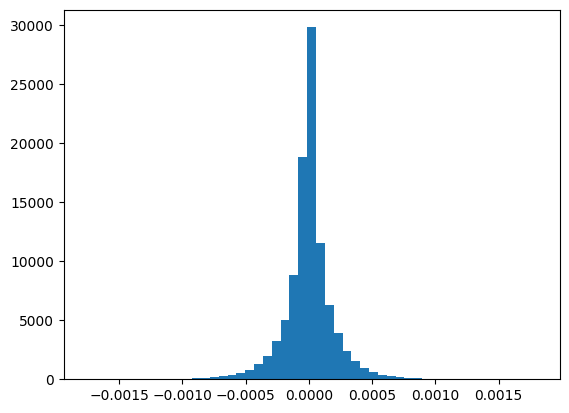

In [61]:
_ = plt.hist(_mtrue[:, :, 0].ravel(), bins=51)
_mtrue[:, :, 0].mean(), _mtrue[:, :, 0].std()

(array([ 1.,  2.,  2.,  3.,  4.,  2.,  3.,  6.,  7.,  5., 35., 10.,  7.,
         4.,  2.,  2.,  0.,  0.,  1.,  2.,  2.]),
 array([-0.00138573, -0.00134962, -0.00131351, -0.0012774 , -0.00124129,
        -0.00120518, -0.00116907, -0.00113297, -0.00109686, -0.00106075,
        -0.00102464, -0.00098853, -0.00095242, -0.00091631, -0.0008802 ,
        -0.00084409, -0.00080798, -0.00077187, -0.00073576, -0.00069965,
        -0.00066354, -0.00062743]),
 <BarContainer object of 21 artists>)

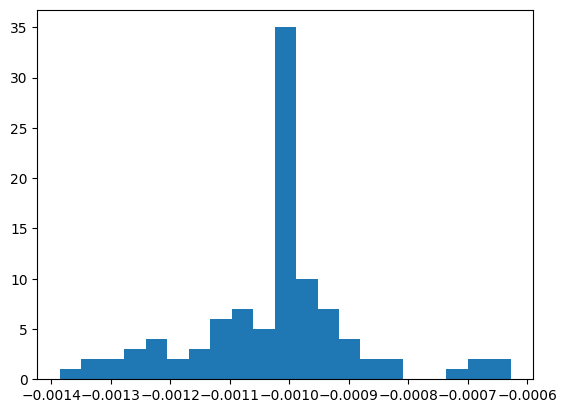

In [62]:
plt.hist(ms2, bins=21)

(array([ 0.,  1.,  1.,  2.,  1.,  6., 11.,  6., 14., 12.,  8., 12.,  6.,
         9.,  3.,  1.,  2.,  1.,  2.,  1.,  0.]),
 array([0.01907482, 0.01916541, 0.01925601, 0.01934661, 0.0194372 ,
        0.0195278 , 0.0196184 , 0.01970899, 0.01979959, 0.01989019,
        0.01998079, 0.02007138, 0.02016198, 0.02025258, 0.02034317,
        0.02043377, 0.02052437, 0.02061496, 0.02070556, 0.02079616,
        0.02088675, 0.02097735]),
 [<matplotlib.patches.Polygon at 0x7f3720fd0950>])

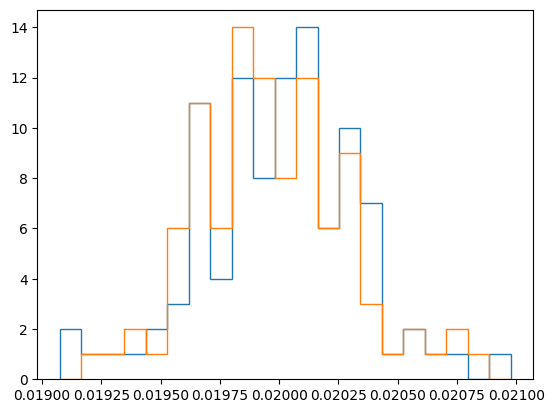

In [63]:
x1 = jnp.median(gp[:, :, 0], axis=1)
x2 = -jnp.median(gm[:, :, 0], axis=1)

_, bins, _ = plt.hist(x1, bins=21, histtype='step')
plt.hist(x2, bins=bins, histtype='step')

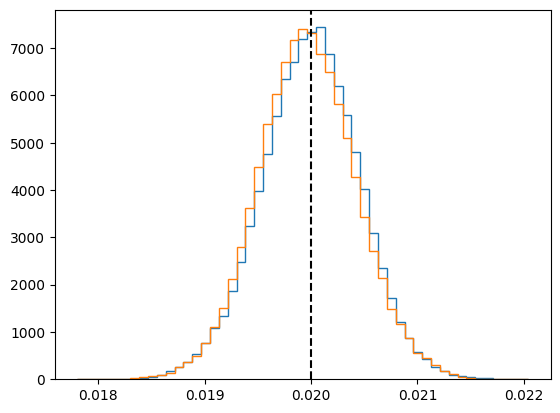

In [64]:
_, bins, _ = plt.hist(gp[:, :, 0].ravel(), bins=51, histtype='step')
plt.hist(-gm[:, :, 0].ravel(), bins=bins, histtype='step')
plt.axvline(0.02, ls='--', c='k')

In [65]:
jnp.median(gp[:, :, 0], axis=1).mean(), jnp.median(gm[:, :, 0], axis=1).mean()

(Array(0.01999493, dtype=float64), Array(-0.01996456, dtype=float64))

(array([  3.,   8.,  44.,  81., 152., 225., 201., 151.,  92.,  32.,  11.]),
 array([-0.00548824, -0.00461051, -0.00373277, -0.00285504, -0.0019773 ,
        -0.00109956, -0.00022183,  0.00065591,  0.00153364,  0.00241138,
         0.00328911,  0.00416685]),
 <BarContainer object of 11 artists>)

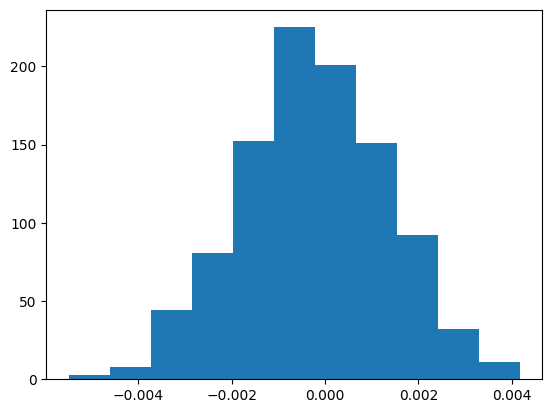

In [66]:
mdummy = (gp[:, :, 0].mean(axis=0) * 2) / 2/ 0.02 - 1
plt.hist(mdummy, bins=11)

In [67]:
x = (jnp.median(gp[:, :, 0], axis=1)  - jnp.median(gm[:, :, 0], axis=1)) / 2/ 0.02 - 1
x.mean()

Array(-0.00101265, dtype=float64)

(array([  3.,  23.,  57., 153., 282., 236., 169.,  55.,  16.,   6.]),
 array([0.01907994, 0.01930172, 0.0195235 , 0.01974529, 0.01996707,
        0.02018885, 0.02041063, 0.02063241, 0.02085419, 0.02107598,
        0.02129776]),
 <BarContainer object of 10 artists>)

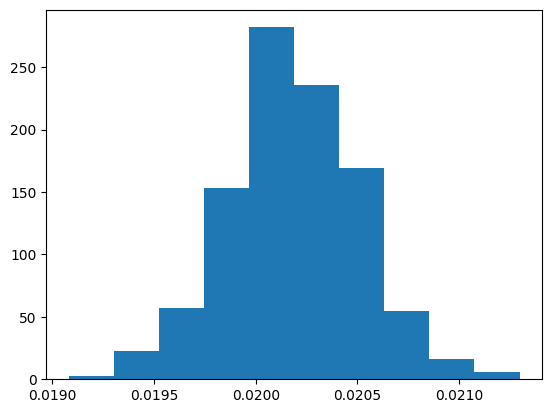

In [68]:
plt.hist(gp[0, :, 0]) 

In [69]:
ms2.mean(), ms2.std()

(Array(-0.00102181, dtype=float64), Array(0.00013743, dtype=float64))

In [70]:
ms2.mean() / ms2.std()

Array(-7.43488827, dtype=float64)

## Together now 

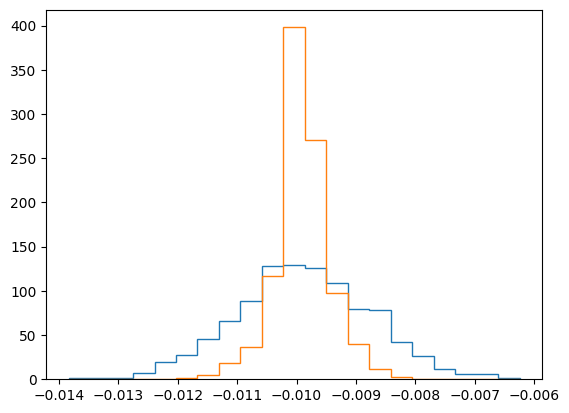

In [112]:
_, bins, _ = plt.hist(ms, bins=21, histtype='step') 
plt.hist(ms2, bins=bins, histtype='step');

In [113]:
ms.std() / ms2.std()

Array(2.47003265, dtype=float64)